In [1]:
import os
os.chdir('/Users/beth/Documents/Metis/metis_project_3_files/clinical_trials/')
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [35]:
from sklearn.impute import KNNImputer

In [3]:
from sklearn.metrics import roc_auc_score, roc_curve, f1_score

In [7]:
from sklearn.model_selection import StratifiedKFold

# Import data

In [2]:
basic_info_df = pd.read_csv('All_basic_info_pandas.csv', quotechar='"')
basic_info_df.drop(['Unnamed: 0','Rank','BriefTitle', 'Condition', \
            'Keyword','WhyStopped','StartDate','PrimaryCompletionDate','CompletionDate'],\
               axis=1, inplace=True)
basic_info_df=basic_info_df.add_suffix('_basic')

In [3]:
outcomes_df = pd.read_csv('All_outcomes_pandas.csv', quotechar='"')
outcomes_df.drop(['Unnamed: 0','Rank'], axis=1, inplace=True)
outcomes_df=outcomes_df.add_suffix('_outcome')

In [4]:
study_design_df = pd.read_csv('All_study_design_pandas.csv', quotechar='"')
study_design_df.drop(['Unnamed: 0','Rank','DesignPrimaryPurpose','Phase','DesignInterventionModel','DesignInterventionModelDescription',\
            'DesignWhoMasked','DesignAllocation','ArmGroupLabel','EnrollmentType','EnrollmentCount',\
            'ArmGroupType','ArmGroupDescription','InterventionType','InterventionName',\
            'InterventionOtherName','InterventionDescription'], axis=1, inplace=True)
study_design_df=study_design_df.add_suffix('_design')

In [5]:
eligibility_df = pd.read_csv('All_elig_df_pandas.csv', quotechar='"')
eligibility_df.drop(['Unnamed: 0','Rank','Gender','GenderBased','MinimumAge',\
            'MaximumAge','HealthyVolunteers','EligibilityCriteria','IPDSharing', \
            'ResponsiblePartyType','ResponsiblePartyInvestigatorAffiliation','LeadSponsorName','CollaboratorName', \
            'OverallOfficialAffiliation','LocationFacility','LocationCity','LocationState','LocationCountry'],\
            axis=1, inplace=True)
eligibility_df=eligibility_df.add_suffix('_elig')

In [6]:
investigators_df = pd.read_csv('All_invest_df_pandas.csv', quotechar='"')
investigators_df.drop(['Unnamed: 0','Rank','nan',"For additional information regarding investigative sites for this trial, contact 1-877-CTLILLY (1-877-285-4559, 1-317-615-4559) Mon - Fri from 9 AM to 5 PM Eastern Time (UTC/GMT - 5 hours, EST), or speak with your personal physician.", \
            'nan.1',"For additional information regarding investigative sites for this trial, contact 1-877-CTLILLY (1-877-285-4559, 1-317-615-4559) Monday-Friday from 9:00 AM to 5:00 PM Eastern Time (UTC/GMT - 5 hours, EST), or speak with your personal physician"], \
            axis=1,inplace=True)

In [7]:
final = pd.merge(basic_info_df,outcomes_df,how="inner",left_on='NCTId_basic', right_on='NCTId_outcome')
final = pd.merge(final,study_design_df,how="inner",left_on='NCTId_basic', right_on='NCTId_design')
final = pd.merge(final,eligibility_df,how="inner",left_on='NCTId_basic', right_on='NCTId_elig')
final = pd.merge(final,investigators_df,how="inner",left_on='NCTId_basic', right_on='NCTId')

In [8]:
del basic_info_df, outcomes_df, study_design_df, eligibility_df, investigators_df 

In [9]:
final.loc[:,['NCTId','NCTId_basic','NCTId_elig','NCTId_design','NCTId_outcome']]

,NCTId,NCTId_basic,NCTId_elig,NCTId_design,NCTId_outcome
0,NCT00049660,NCT00049660,NCT00049660,NCT00049660,NCT00049660
1,NCT00503321,NCT00503321,NCT00503321,NCT00503321,NCT00503321
2,NCT00312442,NCT00312442,NCT00312442,NCT00312442,NCT00312442
3,NCT00507429,NCT00507429,NCT00507429,NCT00507429,NCT00507429
4,NCT00418574,NCT00418574,NCT00418574,NCT00418574,NCT00418574
...,...,...,...,...,...
18120,NCT03560739,NCT03560739,NCT03560739,NCT03560739,NCT03560739
18121,NCT00034021,NCT00034021,NCT00034021,NCT00034021,NCT00034021
18122,NCT01256437,NCT01256437,NCT01256437,NCT01256437,NCT01256437
18123,NCT01484184,NCT01484184,NCT01484184,NCT01484184,NCT01484184


In [10]:
final.drop(['NCTId','NCTId_basic','NCTId_elig','NCTId_design','NCTId_outcome'],axis=1,inplace=True)

# Train/Test 80/20 Split 
### And dealing with null values

In [11]:
final.columns[final.isnull().sum(axis=0) > 0]

Index(['start_year_basic', 'start_month_basic', 'prim_max_time_days_outcome',
       'NumberArms_design', 'location_count'],
      dtype='object')

In [12]:
final['prim_max_time_days_outcome'].isnull().sum(axis=0)

6186

In [13]:
final['NumberArms_design'].isnull().sum(axis=0)

3611

In [14]:
final['location_count'].isnull().sum(axis=0)

1650

In [15]:
final['start_year_basic'].isnull().sum(axis=0)

161

In [16]:
final['start_month_basic'].isnull().sum(axis=0)

161

I decided to use KNNImputer to fill in the values using the most common value from thier 5 K-nearest neighbors.

I should only impute on the training data, and the applt the imputation predictions to the validation and test data. it is important to scale the data, and also only use the Training set. I am also going to make a new column for whether I imputed or not

In [17]:
final['prim_max_time_imputed']=final['prim_max_time_days_outcome'].isnull()
final['NumberArms_design_imputed']=final['NumberArms_design'].isnull()
final['location_count_imputed']=final['location_count'].isnull()
final['start_year_basic']=final['start_year_basic'].isnull()
final['start_month_basic']=final['start_month_basic'].isnull()

In [18]:
X=final.drop('OverallStatus_basic',axis=1)
y=final['OverallStatus_basic']

In [21]:
column_names = X.columns

Test/validate/train split

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, shuffle=True, random_state=33)

In [20]:
X_train.shape

(14500, 400)

In [21]:
y_train.shape

(14500,)

In [22]:
X_test.shape

(3625, 400)

In [23]:
y_test.shape

(3625,)

In [24]:
del final, X, y

Using KNN Imputer

In [25]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [42]:
ss

StandardScaler(copy=True, with_mean=True, with_std=True)

In [32]:
with open('scaling.pickle', 'wb') as write_file:
    pickle.dump(ss, write_file)


In [36]:
imputer = KNNImputer(n_neighbors=5)

X_train_scaled = imputer.fit_transform(X_train_scaled)

In [30]:
X_test_scaled = imputer.transform(X_test_scaled)

In [39]:
X_train = ss.inverse_transform(X_train_scaled)

X_test = ss.inverse_transform(X_test_scaled)

In [40]:
averages=X_train.mean(axis=0)

In [41]:
with open('average.pickle', 'wb') as write_file:
    pickle.dump(averages, write_file)

In [32]:
with open('X_test.pickle','wb') as write_file:
    pickle.dump(X_test,write_file)
with open('y_test.pickle','wb') as write_file:
    pickle.dump(y_test,write_file)
with open('X_train.pickle','wb') as write_file:
    pickle.dump(X_train,write_file)
with open('y_train.pickle','wb') as write_file:
    pickle.dump(y_train,write_file)
    
with open('X_test_scaled.pickle','wb') as write_file:
    pickle.dump(X_test_scaled,write_file)
with open('X_train_scaled.pickle','wb') as write_file:
    pickle.dump(X_train_scaled,write_file)



In [5]:
#with open('X_test.pickle','rb') as read_file:
#    X_test = pickle.load(read_file)
#with open('y_test.pickle','rb') as read_file:
#    y_test = pickle.load(read_file)
with open('X_train.pickle','rb') as read_file:
    X_train = pickle.load(read_file)
with open('y_train.pickle','rb') as read_file:
    y_train = pickle.load(read_file)
    
#with open('X_test_scaled.pickle','rb') as read_file:
#    X_test_scaled = pickle.load(read_file)
with open('X_train_scaled.pickle','rb') as read_file:
    X_train_scaled = pickle.load(read_file)



In [4]:
from sklearn.model_selection import GridSearchCV

# Choosing metric to focus on

Because Terminated trials are the minority class, and are more interesting and useful to classify, I originally wanted to focus on Termianted Recall using an F-beta score with a beta of 2 or 3. However, this ultimately resulted in models where the optimal threshold was 0, and calling everything as 'Terminated'. 

I decided to focus on improving the F1 score of Terminated. The baseline of this score is 0.35


In [377]:
print(classification_report(y_train, ['Terminated']*len(y_train),zero_division=1))

              precision    recall  f1-score   support

   Completed       1.00      0.00      0.00     11452
  Terminated       0.21      1.00      0.35      3048

    accuracy                           0.21     14500
   macro avg       0.61      0.50      0.17     14500
weighted avg       0.83      0.21      0.07     14500



if all are voted 'Terminated' the recall of 'Terminated' is 0.21,
The F1 score is 0.35

# Oversampling

Oversampling may help since there is a large class imbalance, and the class of interest 'Terminated' is underrepresented. From playing around with the data predictions KNN I found that ADASYN made the Recall of the Terminated Class better than SMOTE or Random Oversampling. 

In [13]:
from imblearn.over_sampling import ADASYN
X_adasyn, y_adasyn = ADASYN(random_state=42).fit_sample(X_train_scaled,y_train)

In [35]:
from collections import Counter

In [36]:
Counter(y_adasyn)

Counter({'Completed': 11452, 'Terminated': 11401})

# kNN model Optimization

In [34]:
from sklearn.neighbors import KNeighborsClassifier

In [46]:
param_grid = [{'n_neighbors': [3,4,5,6],
               'weights': ['distance', 'uniform']}]

search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3, n_jobs=-1, scoring='f1')

In [14]:
#I determined that 'Terminated' is predicted as 1 and 'Completed' is predicted as 0
y_train_adasyn_01 = []
for i in y_adasyn:
    if i=='Completed':
        y_train_adasyn_01.append(0)
    if i=="Terminated":
        y_train_adasyn_01.append(1)

In [48]:
search.fit(X_adasyn, y_train_adasyn_01)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid=[{'n_neighbors': [3, 4, 5, 6],
                          'weights': ['distance', 'uniform']}],
             scoring='f1')

In [49]:
search.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [35]:
knn = KNeighborsClassifier(n_neighbors=4, weights='distance')

In [37]:
skf = StratifiedKFold(n_splits=3)

In [38]:
train_index, test_index = next(iter(skf.split(X_train_scaled, y_train)))

In [39]:
X_train_cv1 = X_train_scaled[train_index]
X_validate_cv1 = X_train_scaled[test_index]

In [40]:
y_validate_cv1 = y_train.iloc[test_index]
y_train_cv1 = y_train.iloc[train_index]

In [43]:
X_adasyn_train, y_adasyn_train = ADASYN(random_state=42).fit_sample(X_train_cv1,y_train_cv1)

In [44]:
knn.fit(X_adasyn_train,y_adasyn_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [168]:
preds = knn.predict(X_validate_cv1)

In [169]:
confusion = confusion_matrix(y_validate_cv1, preds)

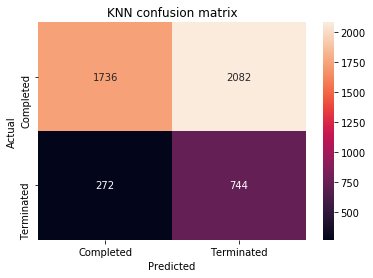

In [170]:
sns.heatmap(confusion, annot=True,
           xticklabels=['Completed','Terminated'],
           yticklabels=['Completed','Terminated'],fmt='.0f')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('KNN confusion matrix');

In [171]:
print(classification_report(y_validate_cv1, preds))

              precision    recall  f1-score   support

   Completed       0.86      0.45      0.60      3818
  Terminated       0.26      0.73      0.39      1016

    accuracy                           0.51      4834
   macro avg       0.56      0.59      0.49      4834
weighted avg       0.74      0.51      0.55      4834



In [173]:
fpr, tpr, thresholds = roc_curve(y_validate_cv1, knn.predict_proba(X_validate_cv1)[:,1], pos_label="Terminated")

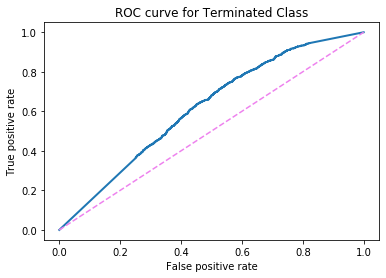

In [174]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Terminated Class');

In [175]:
#The best threshold according to the ROC curve
thresholds[np.argmax(tpr - fpr)]

0.4967556244707593

In [47]:
y_validate_01 = []
for i in y_validate_cv1:
    if i=='Completed':
        y_validate_01.append(0)
    if i=="Terminated":
        y_validate_01.append(1)

In [50]:
F1_list = []
# Will take some time
for i in np.arange(0,1,0.2):
    preds = knn.predict_proba(X_validate_cv1)[:,1] > i
    F1 = f1_score(y_validate_01,preds)
    F1_list.append(F1)

Text(0, 0.5, 'F1')

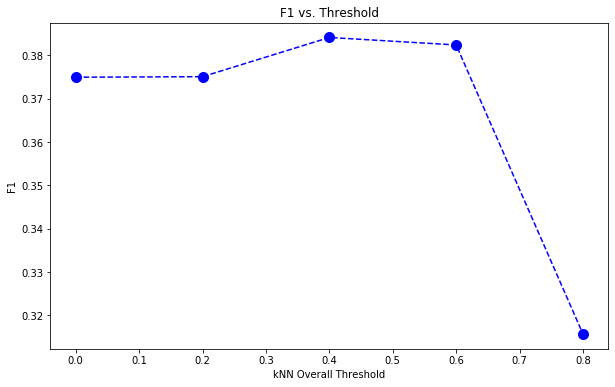

In [53]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0,1,0.2), F1_list, color="blue", linestyle="dashed", marker="o", markersize=10)
plt.title("F1 vs. Threshold")
plt.xlabel("kNN Overall Threshold")
plt.ylabel("F1")

### Compared to a similar non-oversampled KNN model

In [124]:
knn.fit(X_train_cv1,y_train_cv1)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [125]:
preds = knn.predict(X_validate_cv1)

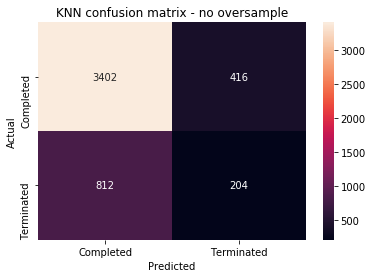

In [126]:
confusion = confusion_matrix(y_validate_cv1, preds)

sns.heatmap(confusion, annot=True,
           xticklabels=['Completed','Terminated'],
           yticklabels=['Completed','Terminated'],fmt='.0f')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('KNN confusion matrix - no oversample');

Using oversampling was really important for kNN

In [194]:
knn = KNeighborsClassifier(n_neighbors=4, weights='distance')

knn.fit(X_adasyn,y_adasyn)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [195]:
with open('knn.pickle', 'wb') as write_file:
    pickle.dump(knn, write_file)

# Logistic Regression Optimization

Using class_bal

In [15]:
#I determined that 'Terminated' is predicted as 1 and 'Completed' is predicted as 0
y_train_01 = []
for i in y_train:
    if i=='Completed':
        y_train_01.append(0)
    if i=="Terminated":
        y_train_01.append(1)

In [55]:
param_grid = [{'C': [0.1, 0.5, 1],
               'l1_ratio': [0, 0.5, 1]}]

search = GridSearchCV(LogisticRegression(class_weight='balanced', solver='saga', penalty='elasticnet', max_iter=500), \
                      param_grid, cv=3, n_jobs=-1, scoring='f1')

search.fit(X_train_scaled, y_train_01)

GridSearchCV(cv=3,
             estimator=LogisticRegression(class_weight='balanced', max_iter=500,
                                          penalty='elasticnet', solver='saga'),
             n_jobs=-1,
             param_grid=[{'C': [0.1, 0.5, 1], 'l1_ratio': [0, 0.5, 1]}],
             scoring='f1')

In [56]:
search.best_params_

{'C': 0.1, 'l1_ratio': 1}

In [8]:
skf = StratifiedKFold(n_splits=3)

In [9]:
train_index, test_index = next(iter(skf.split(X_train_scaled, y_train)))

In [10]:
X_train_cv1 = X_train_scaled[train_index]
X_validate_cv1 = X_train_scaled[test_index]

In [11]:
y_validate_cv1 = y_train.iloc[test_index]
y_train_cv1 = y_train.iloc[train_index]

In [57]:
lr = LogisticRegression(class_weight='balanced', solver='saga', C=0.1, l1_ratio=1, penalty='elasticnet',max_iter=500)

In [58]:
lr = lr.fit(X_train_cv1, y_train_cv1)

In [137]:
preds = lr.predict(X_validate_cv1)

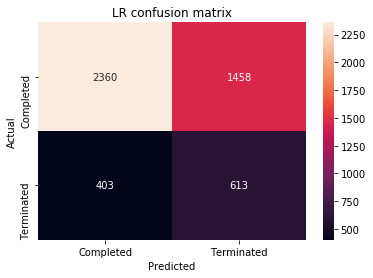

In [138]:
confusion = confusion_matrix(y_validate_cv1, preds)

sns.heatmap(confusion, annot=True,
           xticklabels=['Completed','Terminated'],
           yticklabels=['Completed','Terminated'],fmt='.0f')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LR confusion matrix');

In [139]:
print(classification_report(y_validate_cv1, preds))

              precision    recall  f1-score   support

   Completed       0.85      0.62      0.72      3818
  Terminated       0.30      0.60      0.40      1016

    accuracy                           0.62      4834
   macro avg       0.58      0.61      0.56      4834
weighted avg       0.74      0.62      0.65      4834



In [229]:
fpr, tpr, thresholds = roc_curve(y_validate_cv1, lr.predict_proba(X_validate_cv1)[:,1], pos_label="Terminated")

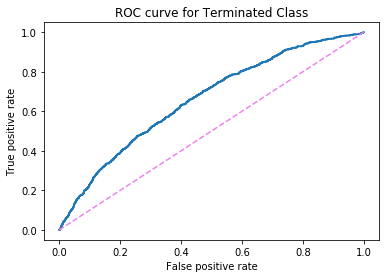

In [141]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Terminated Class');

In [142]:
#The best threshold according to the ROC curve
thresholds[np.argmax(tpr - fpr)]

0.47569952487489936

In [29]:
y_validate_01 = []
for i in y_validate_cv1:
    if i=='Completed':
        y_validate_01.append(0)
    if i=="Terminated":
        y_validate_01.append(1)

In [145]:
print(classification_report(y_validate_01,lr.predict_proba(X_validate_cv1)[:,1] > 0.4757))

              precision    recall  f1-score   support

           0       0.86      0.57      0.69      3818
           1       0.29      0.66      0.40      1016

    accuracy                           0.59      4834
   macro avg       0.58      0.62      0.55      4834
weighted avg       0.74      0.59      0.63      4834



In [60]:
F1_list = []
for i in np.arange(0,1,0.1):
    preds = lr.predict_proba(X_validate_cv1)[:,1] > i
    F1 = f1_score(y_validate_01,preds)
    F1_list.append(F1)

Text(0, 0.5, 'F1')

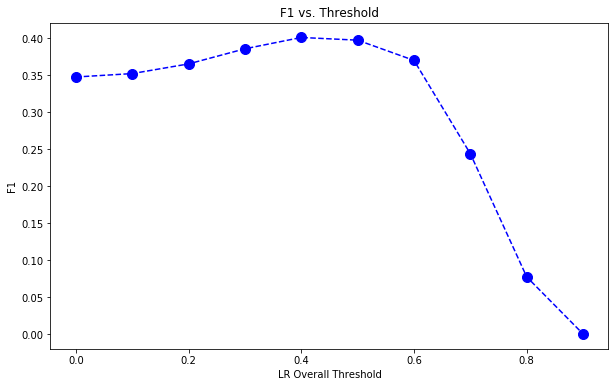

In [61]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0,1,0.1), F1_list, color="blue", linestyle="dashed", marker="o", markersize=10)
plt.title("F1 vs. Threshold")
plt.xlabel("LR Overall Threshold")
plt.ylabel("F1")

In [197]:
lr = LogisticRegression(class_weight='balanced', solver='saga', \
                        C=0.1, l1_ratio=1, penalty='elasticnet',max_iter=500)

lr = lr.fit(X_train_scaled, y_train)

In [198]:
coefs = pd.DataFrame({'column':column_names,'coef':lr.coef_.flatten()}).sort_values('coef')

In [199]:
coefs

,column,coef
151,sponsor_Alliance for Clinical Trials in Oncology,-0.152527
147,sponsor_Memorial Sloan Kettering Cancer Center,-0.148971
145,sponsor_National Cancer Institute (NCI),-0.130703
169,China,-0.128382
149,sponsor_Eli Lilly and Company,-0.113230
...,...,...
154,sponsor_European Organisation for Research and...,0.125872
34,OversightHasDMC_Yes_basic,0.165697
99,Parallel Assignment_design,0.306869
101,Single Group Assignment_design,0.318542


In [200]:
coefs.head(20)

,column,coef
151,sponsor_Alliance for Clinical Trials in Oncology,-0.152527
147,sponsor_Memorial Sloan Kettering Cancer Center,-0.148971
145,sponsor_National Cancer Institute (NCI),-0.130703
169,China,-0.128382
149,sponsor_Eli Lilly and Company,-0.113230
218,Toronto,-0.095859
220,Wichita,-0.095820
58,bevacizumab_design,-0.092326
277,Sioux Falls,-0.088797
162,official_Dana-Farber Cancer Institute,-0.087624


In [203]:
coefs.tail(20)

,column,coef
10,leukemia_basic,0.075324
172,Canada,0.076082
255,Charleston,0.076086
56,surgery_design,0.076686
130,metasta_elig,0.077749
92,Diagnostic_design,0.078150
28,IsFDARegulatedDrug_Yes_basic,0.080065
263,Athens,0.080930
166,location_count,0.081129
234,Minneapolis,0.081935


In [201]:
with open('logistic_coefs.pickle', 'wb') as write_file:
    pickle.dump(coefs, write_file)

In [202]:
with open('logistic_regression.pickle', 'wb') as write_file:
    pickle.dump(lr, write_file)

# SVM optimization

In [17]:
from sklearn.svm import SVC

In [18]:
param_grid = [{'kernel': ['linear','poly','rbf']}]

search = GridSearchCV(SVC(class_weight='balanced', probability=True, degree=2, C=0.1), \
                      param_grid, cv=2, n_jobs=-1, scoring='f1')
                      
search.fit(X_train_scaled, y_train_01)

GridSearchCV(cv=2,
             estimator=SVC(C=0.1, class_weight='balanced', degree=2,
                           probability=True),
             n_jobs=-1, param_grid=[{'kernel': ['linear', 'poly', 'rbf']}],
             scoring='f1')

In [19]:
search.best_params_

{'kernel': 'rbf'}

In [20]:
svc = SVC(class_weight='balanced', probability=True, C=0.1, \
          kernel = 'rbf' )

In [21]:
svc = svc.fit(X_train_cv1, y_train_cv1)

In [22]:
preds = svc.predict(X_validate_cv1)

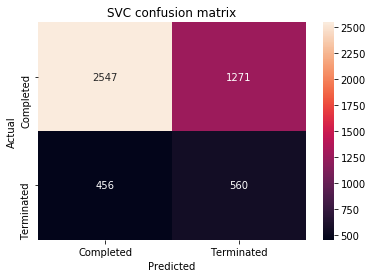

In [23]:
confusion = confusion_matrix(y_validate_cv1, preds)

sns.heatmap(confusion, annot=True,
           xticklabels=['Completed','Terminated'],
           yticklabels=['Completed','Terminated'],fmt='.0f')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SVC confusion matrix');

In [24]:
print(classification_report(y_validate_cv1, preds))

              precision    recall  f1-score   support

   Completed       0.85      0.67      0.75      3818
  Terminated       0.31      0.55      0.39      1016

    accuracy                           0.64      4834
   macro avg       0.58      0.61      0.57      4834
weighted avg       0.73      0.64      0.67      4834



In [25]:
fpr, tpr, thresholds = roc_curve(y_validate_cv1, svc.predict_proba(X_validate_cv1)[:,1], pos_label="Terminated")

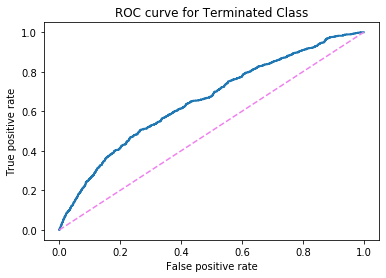

In [26]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Terminated Class');

In [27]:
#The best threshold according to the ROC curve
thresholds[np.argmax(tpr - fpr)]

0.23969734354764274

In [30]:
F1_list = []
for i in np.arange(0,1,0.2):
    preds = svc.predict_proba(X_validate_cv1)[:,1] > i
    F1 = f1_score(y_validate_01,preds)
    F1_list.append(F1)

Text(0, 0.5, 'F1')

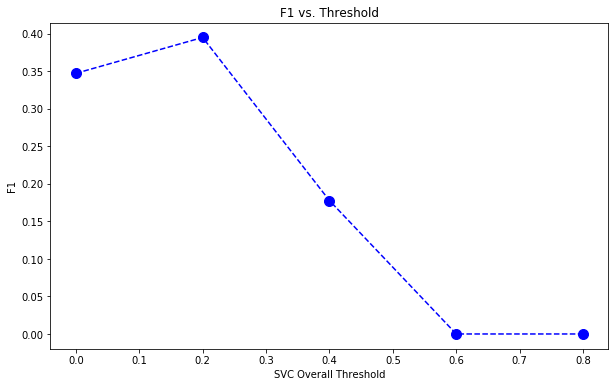

In [61]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0,1,0.2), F1_list, color="blue", linestyle="dashed", marker="o", markersize=10)
plt.title("F1 vs. Threshold")
plt.xlabel("SVC Overall Threshold")
plt.ylabel("F1")

In [33]:
print(classification_report(y_validate_01,svc.predict_proba(X_validate_cv1)[:,1] > thresholds[np.argmax(tpr - fpr)]))

              precision    recall  f1-score   support

           0       0.85      0.73      0.79      3818
           1       0.33      0.51      0.40      1016

    accuracy                           0.68      4834
   macro avg       0.59      0.62      0.59      4834
weighted avg       0.74      0.68      0.70      4834



In [34]:
svc = SVC(class_weight='balanced', probability=True, C=0.1, \
          kernel = 'rbf' )

svc.fit(X_train_scaled, y_train)

SVC(C=0.1, class_weight='balanced', probability=True)

In [35]:
with open('svc.pickle', 'wb') as write_file:
    pickle.dump(svc, write_file)

# Naive Bayes Optimization

In [36]:
from sklearn.naive_bayes import MultinomialNB, ComplementNB

MultinomialNB is going to work best with my dataset because I have a mix of 0/1 (Bernoulli) data, count (Multinomial) data and continous (Gaussian) data. Bernoulli would count all non-zero values as 1, and Gaussian wouldn't appropriately model my binary or count data. 

In [38]:
for i in range(1,397):
    if X_train[:,i].min() < 0:
        print(i)
        #print(column_names[i])

19
21
51
52
53
114
123
147
186
206
244
277
289


In [39]:
X_train[:,19].min()

-1.3877787807814457e-17

In [40]:
X_train_df = pd.DataFrame(X_train)
X_train_df[(X_train_df < 0)] = 0
X_train_2 = np.array(X_train_df)
del X_train_df

In [41]:
y_train_01 = []
for i in y_train:
    if i=='Completed':
        y_train_01.append(0)
    if i=="Terminated":
        y_train_01.append(1)

In [42]:
#alpha is part of the equation for the psuedocount
param_grid = [{'alpha': [0.0000000001, 0.000001, 0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1]}]

search = GridSearchCV(MultinomialNB(), param_grid, cv=3, n_jobs=-1, \
                      scoring='f1')
                      
search.fit(X_train_2, y_train_01)

GridSearchCV(cv=3, estimator=MultinomialNB(), n_jobs=-1,
             param_grid=[{'alpha': [1e-10, 1e-06, 0.0001, 0.001, 0.005, 0.01,
                                    0.05, 0.1, 0.25, 0.5, 0.75, 1]}],
             scoring='f1')

In [43]:
search.best_params_

{'alpha': 1e-10}

In [44]:
train_index, test_index = next(iter(skf.split(X_train_2, y_train)))

In [45]:
X_train_cv1 = X_train_2[train_index]
X_validate_cv1 = X_train_2[test_index]

In [46]:
y_validate_cv1 = y_train.iloc[test_index]
y_train_cv1 = y_train.iloc[train_index]

In [47]:
nb = MultinomialNB(alpha=0.0000000001)
nb.fit(X_train_cv1, y_train_cv1)

MultinomialNB(alpha=1e-10)

In [48]:
preds=nb.predict(X_validate_cv1)

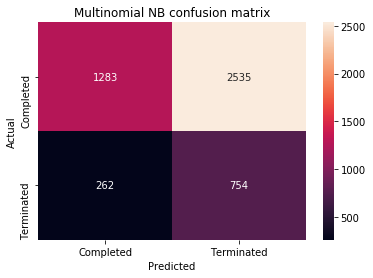

In [49]:
confusion = confusion_matrix(y_validate_cv1, preds)
sns.heatmap(confusion, annot=True,
           xticklabels=['Completed','Terminated'],
           yticklabels=['Completed','Terminated'],fmt='.0f')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Multinomial NB confusion matrix');

In [50]:
print(classification_report(y_validate_cv1, preds))

              precision    recall  f1-score   support

   Completed       0.83      0.34      0.48      3818
  Terminated       0.23      0.74      0.35      1016

    accuracy                           0.42      4834
   macro avg       0.53      0.54      0.41      4834
weighted avg       0.70      0.42      0.45      4834



In [51]:
fpr, tpr, thresholds = roc_curve(y_validate_cv1, nb.predict_proba(X_validate_cv1)[:,1], pos_label="Terminated")

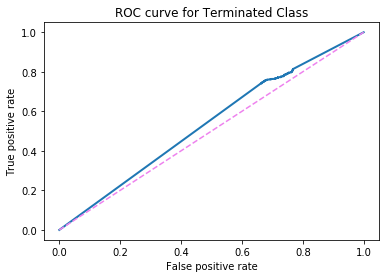

In [52]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Terminated Class');

In [53]:
#The best threshold according to the ROC curve
thresholds[np.argmax(tpr - fpr)]

0.0036412744802954743

In [55]:
#alpha is part of the equation for the psuedocount
param_grid = [{'alpha': [0.0000000001, 0.000001, 0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1]}]

search = GridSearchCV(ComplementNB(), param_grid, cv=3, n_jobs=-1, \
                      scoring='f1')
                      
search.fit(X_train_2, y_train_01)

GridSearchCV(cv=3, estimator=ComplementNB(), n_jobs=-1,
             param_grid=[{'alpha': [1e-10, 1e-06, 0.0001, 0.001, 0.005, 0.01,
                                    0.05, 0.1, 0.25, 0.5, 0.75, 1]}],
             scoring='f1')

In [56]:
search.best_params_

{'alpha': 1e-10}

In [57]:
nb = ComplementNB(alpha=0.0000000001)
nb.fit(X_train_cv1, y_train_cv1)

ComplementNB(alpha=1e-10)

In [58]:
preds=nb.predict(X_validate_cv1)

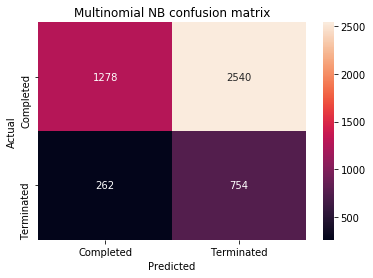

In [59]:
confusion = confusion_matrix(y_validate_cv1, preds)
sns.heatmap(confusion, annot=True,
           xticklabels=['Completed','Terminated'],
           yticklabels=['Completed','Terminated'],fmt='.0f')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Multinomial NB confusion matrix');

In [60]:
print(classification_report(y_validate_cv1, preds))

              precision    recall  f1-score   support

   Completed       0.83      0.33      0.48      3818
  Terminated       0.23      0.74      0.35      1016

    accuracy                           0.42      4834
   macro avg       0.53      0.54      0.41      4834
weighted avg       0.70      0.42      0.45      4834



In [69]:
F1_list = []
for i in np.arange(0,1,0.1):
    preds = nb.predict_proba(X_validate_cv1)[:,1] > i
    F1 = f1_score(y_validate_01,preds)
    F1_list.append(F1)

Text(0, 0.5, 'F1')

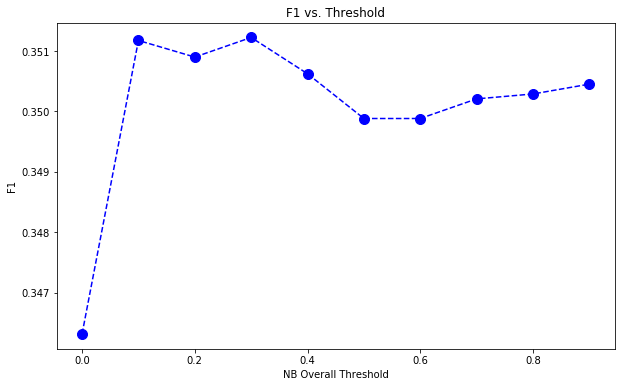

In [70]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0,1,0.1), F1_list, color="blue", linestyle="dashed", marker="o", markersize=10)
plt.title("F1 vs. Threshold")
plt.xlabel("NB Overall Threshold")
plt.ylabel("F1")

In [72]:
print(classification_report(y_validate_01, nb.predict_proba(X_validate_cv1)[:,1] > 0.3))

              precision    recall  f1-score   support

           0       0.83      0.33      0.48      3818
           1       0.23      0.75      0.35      1016

    accuracy                           0.42      4834
   macro avg       0.53      0.54      0.41      4834
weighted avg       0.71      0.42      0.45      4834



In [73]:
nb = MultinomialNB(alpha=0.0000000001)
nb.fit(X_train, y_train)

MultinomialNB(alpha=1e-10)

In [74]:
with open('multinomial_nb.pickle', 'wb') as write_file:
    pickle.dump(nb, write_file)

In [263]:
del knn, lr, svc, nb

# Random Forest Optimization

In [9]:
from sklearn.ensemble import RandomForestClassifier

In [8]:
from imblearn.over_sampling import ADASYN


In [8]:
skf = StratifiedKFold(n_splits=3)

In [9]:
train_index, test_index = next(iter(skf.split(X_train, y_train)))
X_train_cv1 = X_train[train_index]
X_validate_cv1 = X_train[test_index]
y_validate_cv1 = y_train.iloc[test_index]
y_train_cv1 = y_train.iloc[train_index]


In [10]:
train_index, test_index = next(iter(skf.split(X_train_scaled, y_train)))
X_train_cv2 = X_train_scaled[train_index]
X_validate_cv2 = X_train_scaled[test_index]
y_validate_cv2 = y_train.iloc[test_index]
y_train_cv2 = y_train.iloc[train_index]


In [11]:
train_index, test_index = next(iter(skf.split(X_train_scaled, y_train)))
X_train_cv3 = X_train_scaled[train_index]
X_validate_cv3 = X_train_scaled[test_index]
y_validate_cv3 = y_train.iloc[test_index]
y_train_cv3 = y_train.iloc[train_index]


In [ ]:
sum([0.1,0.2])

In [22]:
def graph_param(param,range_of_interest):
    final_scores = []

    for i in range_of_interest:
        scores = []
        for cv in [(X_train_cv1, y_train_cv1,X_validate_cv1,y_validate_cv1), \
                 (X_train_cv2, y_train_cv2,X_validate_cv2,y_validate_cv2), \
                 (X_train_cv3, y_train_cv3,X_validate_cv3,y_validate_cv3)]:
            d={'max_features':i,'class_weight':'balanced'}
            rf = RandomForestClassifier(**d)
            rf.fit(cv[0], cv[1])
            score = f1_score(rf.predict(cv[2]), cv[3], pos_label="Terminated")
            scores.append(score)
        score=sum(scores)/len(scores)
        final_scores.append(score)
    
    x_vals=range_of_interest
    plt.plot(x_vals,final_scores)
    plt.xlabel(param, fontsize=12)
    plt.ylabel('f1', fontsize=12)

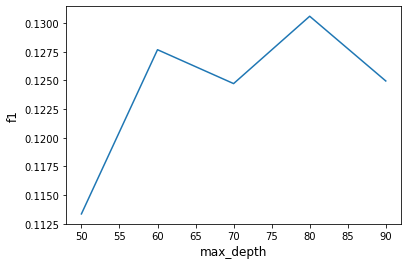

In [23]:
graph_param('max_depth',range(50,100,10)) #default=None is oK

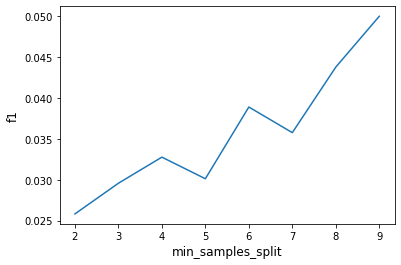

In [24]:
graph_param('min_samples_split',range(2,10)) # default=2 is not best

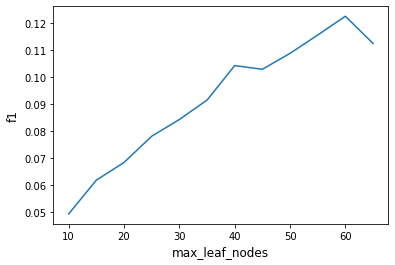

In [25]:
graph_param('max_leaf_nodes',range(10,70,5)) #default=None is OK

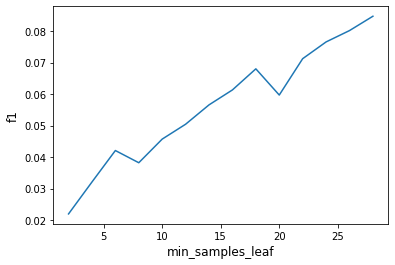

In [26]:
graph_param('min_samples_leaf',range(2,30,2)) #default=1 is NOT best

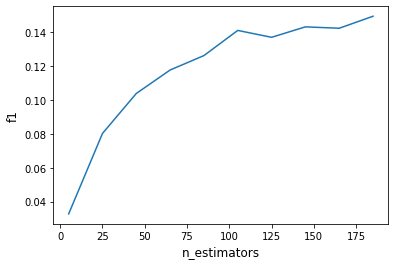

In [27]:
graph_param('n_estimators',range(5,205,20)) #default=100 is ok

In [28]:
np.sqrt(400) #default max_features

20.0

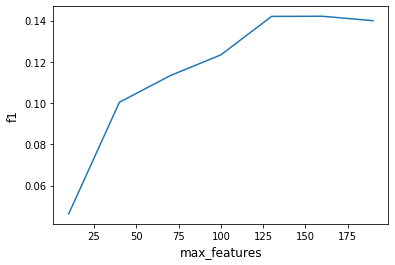

In [29]:
graph_param('max_features',range(10,200,30)) #default value 20 is not best

All the F1 scores are VERY low in the graphs

Random Forests are probably not going to work well for this dataset

# XGBoost

Wow I wasn't able to get this module to download, so I was using the GradientBoostedClassifier from sklearn instead and it was performing as badly as the random forest - I will need to look into this.

In [1]:
import xgboost as xgb

In [9]:
y_train_01 = []
for i in y_train_cv1:
    if i=='Completed':
        y_train_01.append(0)
    if i=="Terminated":
        y_train_01.append(1)

In [10]:
y_validate_01 = []
for i in y_validate_cv1:
    if i=='Completed':
        y_validate_01.append(0)
    if i=="Terminated":
        y_validate_01.append(1)

In [29]:
#0.68 max validation for LR=0.5, min child weights =3


gbm = xgb.XGBRegressor(n_estimaters=3000, objective='binary:logistic', \
                      learning_rate=0.5, min_child_weight=3)

eval_set=[(X_train_cv1, y_train_01),(X_validate_cv1,y_validate_01)] #tracking train/validation error as we go
fit_model = gbm.fit(X_train_cv1, y_train_01, eval_set=eval_set, \
                    eval_metric='auc',early_stopping_rounds=20)

[0]	validation_0-auc:0.63714	validation_1-auc:0.625065
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.665734	validation_1-auc:0.631794
[2]	validation_0-auc:0.67275	validation_1-auc:0.643186
[3]	validation_0-auc:0.680773	validation_1-auc:0.645079
[4]	validation_0-auc:0.68586	validation_1-auc:0.645356
[5]	validation_0-auc:0.692825	validation_1-auc:0.651944
[6]	validation_0-auc:0.695836	validation_1-auc:0.657113
[7]	validation_0-auc:0.70379	validation_1-auc:0.658682
[8]	validation_0-auc:0.709693	validation_1-auc:0.663184
[9]	validation_0-auc:0.715336	validation_1-auc:0.665576
[10]	validation_0-auc:0.719208	validation_1-auc:0.665644
[11]	validation_0-auc:0.722001	validation_1-auc:0.666068
[12]	validation_0-auc:0.725996	validation_1-auc:0.66739
[13]	validation_0-auc:0.730109	validation_1-auc:0.670188
[14]	validation_0-auc:0.733494	validation_1-auc:0.671526
[15

In [30]:
gbm.best_ntree_limit

44

In [50]:
preds=gbm.predict(X_validate_cv1)

In [55]:
preds

array([0.06207483, 0.3444015 , 0.10024903, ..., 0.1129244 , 0.44800702,
       0.03788467], dtype=float32)

In [57]:
preds_bool = preds > 0.2

In [58]:
preds_bool

array([False,  True, False, ..., False,  True, False])

In [41]:
F1_list = []
for i in np.arange(0,1,0.1):
    preds = gbm.predict(X_validate_cv1) > i
    F1 = f1_score(y_validate_01,preds)
    F1_list.append(F1)

Text(0, 0.5, 'F1')

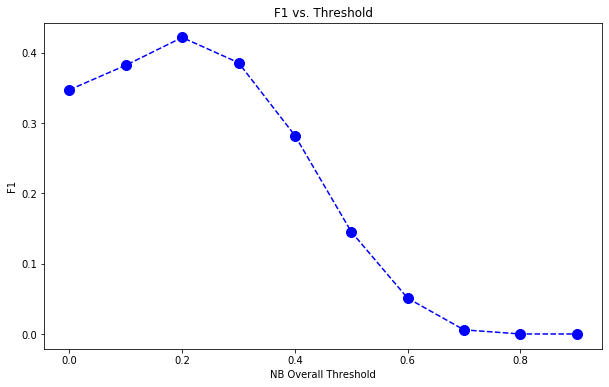

In [42]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0,1,0.1), F1_list, color="blue", linestyle="dashed", marker="o", markersize=10)
plt.title("F1 vs. Threshold")
plt.xlabel("NB Overall Threshold")
plt.ylabel("F1")

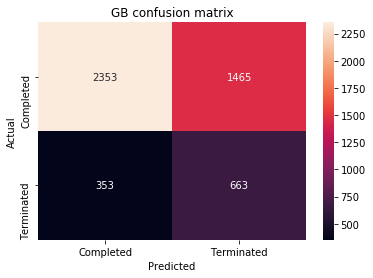

In [59]:
confusion = confusion_matrix(y_validate_01, preds_bool)
sns.heatmap(confusion, annot=True,
           xticklabels=['Completed','Terminated'],
           yticklabels=['Completed','Terminated'],fmt='.0f')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('GB confusion matrix');

In [61]:
print(classification_report(y_validate_01, preds_bool))

              precision    recall  f1-score   support

           0       0.87      0.62      0.72      3818
           1       0.31      0.65      0.42      1016

    accuracy                           0.62      4834
   macro avg       0.59      0.63      0.57      4834
weighted avg       0.75      0.62      0.66      4834



In [62]:
with open('gbm.pickle', 'wb') as write_file:
    pickle.dump(gbm, write_file)

# Ensembl models using SVC, LR and kNN models (pre XGboost)

In [4]:
with open('svc.pickle', 'rb') as read_file:
    svc = pickle.load(read_file)

with open('knn.pickle', 'rb') as read_file:
    knn = pickle.load(read_file)

with open('multinomial_nb.pickle', 'rb') as read_file:
    nb = pickle.load(read_file)

with open('logistic_regression.pickle', 'rb') as read_file:
    lr = pickle.load(read_file)
    
with open('gbm.pickle', 'rb') as read_file:
    gbm = pickle.load(read_file)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator SVC from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator MultinomialNB from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.23.2 when using version 0.22.1. This might lead to breaking code or invalid results. Use at 

In [105]:
model_names=['svc','knn','lr']

In [106]:
model_vars = [svc, knn, lr]

In [107]:
model_list=list(zip(model_names,model_vars))

In [108]:
model_list

[('svc', SVC(C=0.1, class_weight='balanced', probability=True)),
 ('knn', KNeighborsClassifier(n_neighbors=4, weights='distance')),
 ('lr',
  LogisticRegression(C=0.1, class_weight='balanced', l1_ratio=1, max_iter=500,
                     penalty='elasticnet', solver='saga'))]

## Max Voting Classifier

In [109]:
from sklearn.ensemble import VotingClassifier

Because of naive bayes not taking negative values, and other classifiers needing scaled values, which are scaled to have a mean of 0, I am going to drop NB from the ensembl 

In [110]:
skf = StratifiedKFold(n_splits=3)
train_index, test_index = next(iter(skf.split(X_train_scaled, y_train)))
X_train_cv1 = X_train_scaled[train_index]
X_validate_cv1 = X_train_scaled[test_index]
y_validate_cv1 = y_train.iloc[test_index]
y_train_cv1 = y_train.iloc[train_index]

In [111]:
voting_classifer = VotingClassifier(estimators=model_list, voting='hard', 
                                    n_jobs=-1)
voting_classifer.fit(X_train_cv1, y_train_cv1)

VotingClassifier(estimators=[('svc',
                              SVC(C=0.1, class_weight='balanced',
                                  probability=True)),
                             ('knn',
                              KNeighborsClassifier(n_neighbors=4,
                                                   weights='distance')),
                             ('lr',
                              LogisticRegression(C=0.1, class_weight='balanced',
                                                 l1_ratio=1, max_iter=500,
                                                 penalty='elasticnet',
                                                 solver='saga'))],
                 n_jobs=-1)

In [112]:
preds=voting_classifer.predict(X_validate_cv1)

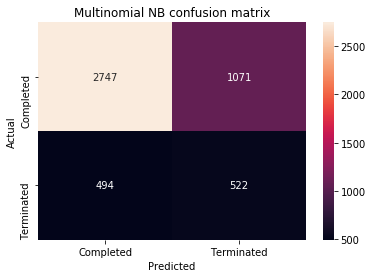

In [113]:
confusion = confusion_matrix(y_validate_cv1, preds)
sns.heatmap(confusion, annot=True,
           xticklabels=['Completed','Terminated'],
           yticklabels=['Completed','Terminated'],fmt='.0f')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Multinomial NB confusion matrix');
#Title it wrong, should be MAX VOTING 

In [114]:
print(classification_report(y_validate_cv1, preds))

              precision    recall  f1-score   support

   Completed       0.85      0.72      0.78      3818
  Terminated       0.33      0.51      0.40      1016

    accuracy                           0.68      4834
   macro avg       0.59      0.62      0.59      4834
weighted avg       0.74      0.68      0.70      4834



Trying the training with an ADASYN oversampled training set

In [67]:
X_adasyn_cv1, y_adasyn_cv1 = ADASYN(random_state=42).fit_sample(X_train_cv1,y_train_cv1)

NameError: name 'ADASYN' is not defined

In [116]:
adasyn_voting_classifier = VotingClassifier(estimators=model_list,
                                    voting='hard', 
                                    n_jobs=-1)
adasyn_voting_classifier.fit(X_adasyn_cv1, y_adasyn_cv1)

VotingClassifier(estimators=[('svc',
                              SVC(C=0.1, class_weight='balanced',
                                  probability=True)),
                             ('knn',
                              KNeighborsClassifier(n_neighbors=4,
                                                   weights='distance')),
                             ('lr',
                              LogisticRegression(C=0.1, class_weight='balanced',
                                                 l1_ratio=1, max_iter=500,
                                                 penalty='elasticnet',
                                                 solver='saga'))],
                 n_jobs=-1)

In [117]:
preds=adasyn_voting_classifier.predict(X_validate_cv1)

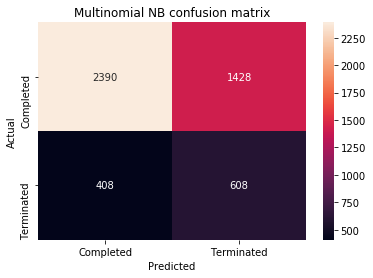

In [118]:
confusion = confusion_matrix(y_validate_cv1, preds)
sns.heatmap(confusion, annot=True,
           xticklabels=['Completed','Terminated'],
           yticklabels=['Completed','Terminated'],fmt='.0f')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Multinomial NB confusion matrix'); 
#Title is wrong, this is MAX VOTING TRAINED ON ADASYN data

In [119]:
print(classification_report(y_validate_cv1, preds))

              precision    recall  f1-score   support

   Completed       0.85      0.63      0.72      3818
  Terminated       0.30      0.60      0.40      1016

    accuracy                           0.62      4834
   macro avg       0.58      0.61      0.56      4834
weighted avg       0.74      0.62      0.65      4834



I'm assuming if I used my pickeled models I can just take the mode of their votes and get the similar scores 

In [129]:
svc_pred = svc.predict(X_validate_cv1)
lr_pred = lr.predict(X_validate_cv1)
knn_pred = knn.predict(X_validate_cv1)

In [137]:
combo = np.array([np.array(lr_pred),np.array(svc_pred),np.array(knn_pred)])

In [144]:
from collections import Counter

In [157]:
combo = np.array([np.array(lr_pred),np.array(svc_pred),np.array(knn_pred)])
preds = []
for i in range(len(y_validate_cv1)):
    counts = Counter(combo[:,i])
    pred = counts.most_common()
    preds.append(pred[0][0])

In [159]:
print(classification_report(y_validate_cv1, preds))

              precision    recall  f1-score   support

   Completed       0.98      0.29      0.45      3818
  Terminated       0.27      0.98      0.42      1016

    accuracy                           0.44      4834
   macro avg       0.63      0.64      0.44      4834
weighted avg       0.83      0.44      0.45      4834



This is actually performing too well because the validation cases were part of the training cases....

I am not sure yet how to incorporate the lower threshold for SVC into this voting classifier as well

## A classifier based on average predicted probability

In [121]:
average_voting_classifier = VotingClassifier(estimators=model_list,
                                    voting='soft', 
                                    n_jobs=-1)
average_voting_classifier.fit(X_adasyn_cv1, y_adasyn_cv1)

VotingClassifier(estimators=[('svc',
                              SVC(C=0.1, class_weight='balanced',
                                  probability=True)),
                             ('knn',
                              KNeighborsClassifier(n_neighbors=4,
                                                   weights='distance')),
                             ('lr',
                              LogisticRegression(C=0.1, class_weight='balanced',
                                                 l1_ratio=1, max_iter=500,
                                                 penalty='elasticnet',
                                                 solver='saga'))],
                 n_jobs=-1, voting='soft')

In [122]:
preds=average_voting_classifier.predict(X_validate_cv1)

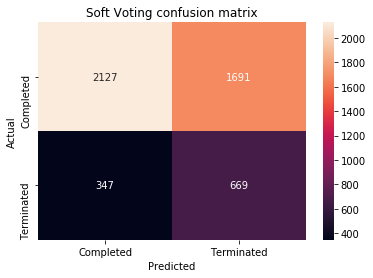

In [123]:
confusion = confusion_matrix(y_validate_cv1, preds)
sns.heatmap(confusion, annot=True,
           xticklabels=['Completed','Terminated'],
           yticklabels=['Completed','Terminated'],fmt='.0f')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Soft Voting confusion matrix');

In [188]:
(669+2127)/(669+347+1691+2127) #accuracy

0.5784029788994621

In [189]:
(669)/(669+1691) #PPV / Terminated Precision

0.28347457627118644

In [192]:
(2127)/(347+2127) #NPV / Complemented Precision

0.8597413096200485

In [124]:
print(classification_report(y_validate_cv1, preds))

              precision    recall  f1-score   support

   Completed       0.86      0.56      0.68      3818
  Terminated       0.28      0.66      0.40      1016

    accuracy                           0.58      4834
   macro avg       0.57      0.61      0.54      4834
weighted avg       0.74      0.58      0.62      4834



In [15]:
y_validate_01 = []
for i in y_validate_cv1:
    if i=='Completed':
        y_validate_01.append(0)
    if i=="Terminated":
        y_validate_01.append(1)

In [126]:
F1_list = []
# Will take some time
for i in np.arange(0,1,0.1):
    preds = average_voting_classifier.predict_proba(X_validate_cv1)[:,1] > i
    F1 = f1_score(y_validate_01,preds)
    F1_list.append(F1)

Text(0, 0.5, 'F1')

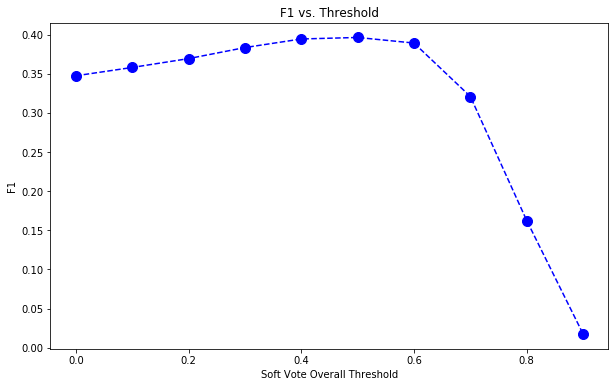

In [128]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0,1,0.1), F1_list, color="blue", linestyle="dashed", marker="o", markersize=10)
plt.title("F1 vs. Threshold")
plt.xlabel("Soft Vote Overall Threshold")
plt.ylabel("F1")

In [129]:
fpr, tpr, thresholds = roc_curve(y_validate_cv1, average_voting_classifier.predict_proba(X_validate_cv1)[:,1], pos_label="Terminated")

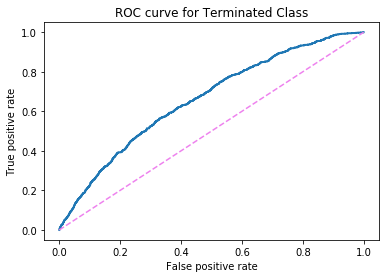

In [130]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Terminated Class');

In [210]:
thresholds[np.argmax(tpr - fpr)]

0.47704091945743804

It would make sense if weights could be added to the predict call, so I don't have to keep training these models.. GridSearch is too slow for this

# Visualizing correctly called Terminated datapoints in each model

In [131]:
X_validate_term = X_validate_cv1[y_validate_cv1=='Terminated']

In [133]:
from sklearn.manifold import TSNE

In [155]:
lr = lr.fit(X_train_cv1, y_train_cv1)

In [156]:
preds = lr.predict(X_validate_term)

In [167]:
correct_lr = list(preds == "Terminated")

In [169]:
knn = knn.fit(X_adasyn_cv1, y_adasyn_cv1)

In [170]:
preds_knn = knn.predict(X_validate_term)

In [171]:
correct_knn = list(preds_knn == "Terminated")

In [173]:
svc = svc.fit(X_train_cv1, y_train_cv1)

In [183]:
preds_svc = svc.predict_proba(X_validate_term)[:,1] > 0.24

In [185]:
correct_svc = list(preds_svc == 1)

In [197]:
preds_svc_term = []
for i in preds_svc:
    if i==1:
        preds_svc_term.append('Terminated')
    else:
        preds_svc_term.append('Completed')

In [199]:
#the overlap between svc and lr predictions on terminated datapoints (out of 1016)
(preds_svc_term==preds).sum()

808

In [181]:
#the overlap between knn and lr predictions on terminated datapoints (out of 1016)
(preds_knn==preds).sum()

651

In [200]:
#the overlap between svc and knn predictions on terminated datapoints (out of 1016)
(preds_svc_term==preds_knn).sum()

603

In [182]:
len(preds_svc)

1016

In [221]:
preds_soft=average_voting_classifier.predict(X_validate_term)

In [224]:
correct_soft = list(preds_soft == 'Terminated')

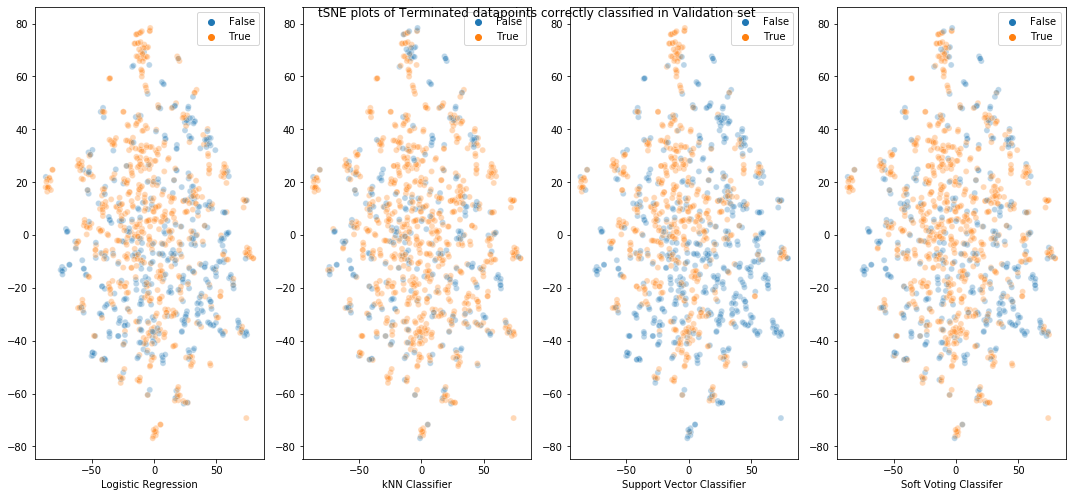

In [354]:
fig, ax = plt.subplots(1,4,figsize=(15,7))

#need to fix this suptitle
fig.suptitle('tSNE plots of Terminated datapoints correctly classified in Validation set')

sns.scatterplot(tsne_xtrain[:, 0], tsne_xtrain[:, 1], hue=correct_lr, alpha = 0.3, ax=ax[0])
ax[0].set_xlabel('Logistic Regression')

sns.scatterplot(tsne_xtrain[:, 0], tsne_xtrain[:, 1], hue=correct_knn, alpha = 0.3, ax=ax[1])

ax[1].set_xlabel('kNN Classifier')

sns.scatterplot(tsne_xtrain[:, 0], tsne_xtrain[:, 1], hue=correct_svc, alpha = 0.3, ax=ax[2])
ax[2].set_xlabel('Support Vector Classifier')

sns.scatterplot(tsne_xtrain[:, 0], tsne_xtrain[:, 1], hue=correct_soft, alpha = 0.3)
ax[3].set_xlabel('Soft Voting Classifer')

plt.tight_layout();



Seems like SVC and LR are producing similar calls on on the Terminated class the same calls, and identifying the same regions of Termianted datapoints. 

I am going to try to make ensembl models with just KNN and LR and see how this changes the metrics. SVC takes a long time to make predictions as well.

# New Soft Voting Classifier with just kNN and LR models

In [205]:
model_names=['knn','lr']

In [206]:
model_vars = [knn, lr]

In [207]:
model_list=list(zip(model_names,model_vars))

In [208]:
average_voting_classifier_2 = VotingClassifier(estimators=model_list,
                                    voting='soft', 
                                    n_jobs=-1)
average_voting_classifier_2.fit(X_adasyn_cv1, y_adasyn_cv1)

VotingClassifier(estimators=[('knn',
                              KNeighborsClassifier(n_neighbors=4,
                                                   weights='distance')),
                             ('lr',
                              LogisticRegression(C=0.1, class_weight='balanced',
                                                 l1_ratio=1, max_iter=500,
                                                 penalty='elasticnet',
                                                 solver='saga'))],
                 n_jobs=-1, voting='soft')

In [209]:
preds_av2=average_voting_classifier_2.predict(X_validate_cv1)

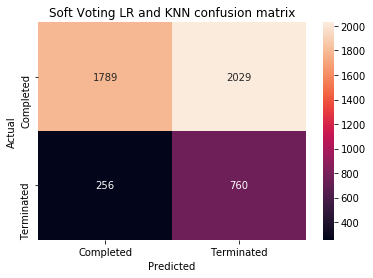

In [210]:
confusion = confusion_matrix(y_validate_cv1, preds_av2)
sns.heatmap(confusion, annot=True,
           xticklabels=['Completed','Terminated'],
           yticklabels=['Completed','Terminated'],fmt='.0f')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Soft Voting LR and KNN confusion matrix');

In [211]:
print(classification_report(y_validate_cv1, preds_av2))

              precision    recall  f1-score   support

   Completed       0.87      0.47      0.61      3818
  Terminated       0.27      0.75      0.40      1016

    accuracy                           0.53      4834
   macro avg       0.57      0.61      0.50      4834
weighted avg       0.75      0.53      0.57      4834



Compared to previous Soft Voting Predictor with KNN, LR and SVC, it retains similar precision, but trades off recall between the two groups. I think this model (LR and KNN) is better, because it is simpler and the increased recall of Terminated is nice

  |       precision|    recall|  f1-score  | support  |
|------------------|----------|------------|----------|
   |Completed      | 0.86     | 0.56   |   0.68   |   3818
  |Terminated  |     0.28  |    0.66   |   0.40    |  1016
 |   accuracy  |         |           |     0.58   |   4834
 |  macro avg   |    0.57   |   0.61   |   0.54   |   4834
|weighted avg   |    0.74   |   0.58   |   0.62    |  4834

In [212]:
F1_list = []
# Will take some time
for i in np.arange(0,1,0.1):
    preds = average_voting_classifier_2.predict_proba(X_validate_cv1)[:,1] > i
    F1 = f1_score(y_validate_01,preds)
    F1_list.append(F1)

Text(0, 0.5, 'F1')

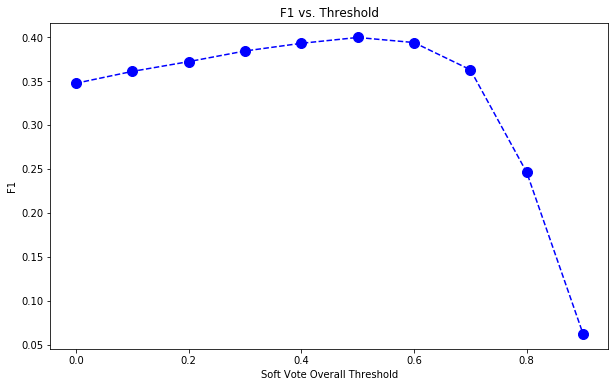

In [213]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(0,1,0.1), F1_list, color="blue", linestyle="dashed", marker="o", markersize=10)
plt.title("F1 vs. Threshold")
plt.xlabel("Soft Vote Overall Threshold")
plt.ylabel("F1")

In [214]:
fpr, tpr, thresholds = roc_curve(y_validate_cv1, average_voting_classifier_2.predict_proba(X_validate_cv1)[:,1], pos_label="Terminated")

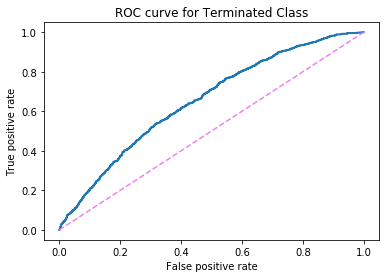

In [215]:
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Terminated Class');

In [216]:
thresholds[np.argmax(tpr - fpr)]

0.6376115028700731

In [347]:
print(classification_report(y_validate_01, average_voting_classifier_2.predict_proba(X_validate_cv1)[:,1] > 0.6376115028700731))

              precision    recall  f1-score   support

           0       0.85      0.68      0.75      3818
           1       0.31      0.54      0.39      1016

    accuracy                           0.65      4834
   macro avg       0.58      0.61      0.57      4834
weighted avg       0.73      0.65      0.68      4834



In [228]:
print(classification_report(y_validate_01, average_voting_classifier_2.predict_proba(X_validate_cv1)[:,1] > 0.55))

              precision    recall  f1-score   support

           0       0.86      0.54      0.66      3818
           1       0.28      0.66      0.39      1016

    accuracy                           0.56      4834
   macro avg       0.57      0.60      0.52      4834
weighted avg       0.73      0.56      0.60      4834



In [272]:
preds_soft_2=average_voting_classifier_2.predict(X_validate_term)

In [273]:
correct_soft_2 = list(preds_soft_2 == 'Terminated')

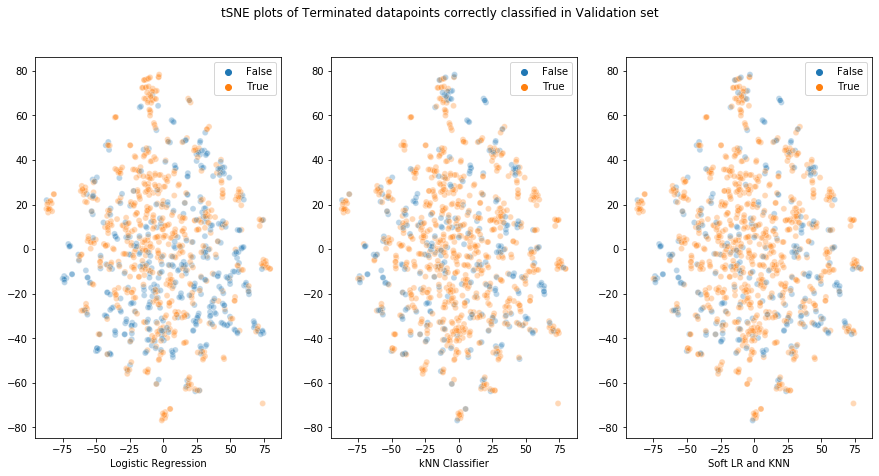

In [350]:
fig, ax = plt.subplots(1,3,figsize=(15,7))

fig.suptitle('tSNE plots of Terminated datapoints correctly classified in Validation set')

sns.scatterplot(tsne_xtrain[:, 0], tsne_xtrain[:, 1], hue=correct_lr, alpha = 0.3, ax=ax[0])
ax[0].set_xlabel('Logistic Regression')

sns.scatterplot(tsne_xtrain[:, 0], tsne_xtrain[:, 1], hue=correct_knn, alpha = 0.3, ax=ax[1])
ax[1].set_xlabel('kNN Classifier')

sns.scatterplot(tsne_xtrain[:, 0], tsne_xtrain[:, 1], hue=correct_soft_2, alpha = 0.3, ax=ax[2])
ax[2].set_xlabel('Soft LR and KNN')

plt.tight_layout;

## Checking model performance on both Phase 3 and Phase 3 trials

In [317]:
with open('coef_names.pickle', 'rb') as read_file:
    columns = pickle.load(read_file)

In [321]:
list(columns).index('Phase 3_design')

96

In [334]:
X_validate_phase3 = X_validate_cv1[X_validate_cv1[:,96] > 0]

In [335]:
y_validate_phase3 = y_validate_cv1[X_validate_cv1[:,96] > 0]

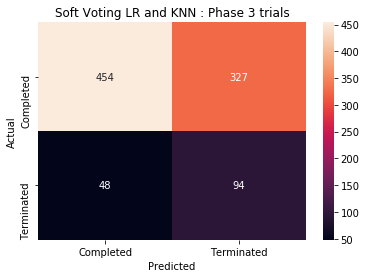

In [336]:
confusion = confusion_matrix(y_validate_phase3, average_voting_classifier_2.predict(X_validate_phase3))
sns.heatmap(confusion, annot=True,
           xticklabels=['Completed','Terminated'],
           yticklabels=['Completed','Terminated'],fmt='.0f')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Soft Voting LR and KNN : Phase 3 trials');

In [340]:
print(classification_report(y_validate_phase3, average_voting_classifier_2.predict(X_validate_phase3)))

              precision    recall  f1-score   support

   Completed       0.90      0.58      0.71       781
  Terminated       0.22      0.66      0.33       142

    accuracy                           0.59       923
   macro avg       0.56      0.62      0.52       923
weighted avg       0.80      0.59      0.65       923



In [341]:
list(columns).index('Phase 2_design')

94

In [342]:
X_validate_phase2 = X_validate_cv1[X_validate_cv1[:,94] > 0]

In [343]:
y_validate_phase2 = y_validate_cv1[X_validate_cv1[:,94] > 0]

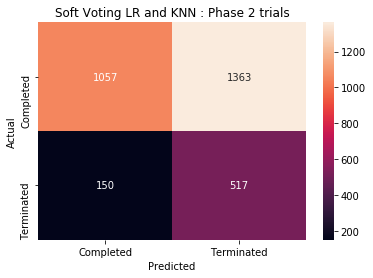

In [345]:
confusion = confusion_matrix(y_validate_phase2, average_voting_classifier_2.predict(X_validate_phase2))
sns.heatmap(confusion, annot=True,
           xticklabels=['Completed','Terminated'],
           yticklabels=['Completed','Terminated'],fmt='.0f')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Soft Voting LR and KNN : Phase 2 trials');

In [346]:
print(classification_report(y_validate_phase2, average_voting_classifier_2.predict(X_validate_phase2)))

              precision    recall  f1-score   support

   Completed       0.88      0.44      0.58      2420
  Terminated       0.28      0.78      0.41       667

    accuracy                           0.51      3087
   macro avg       0.58      0.61      0.49      3087
weighted avg       0.75      0.51      0.54      3087



# A Hard Voting Classifier with just LR and kNN

LR witll be the one it goes with in a tie since L is further in the alphabet then K

In [105]:
model_names=['lr','knn']

In [240]:
model_vars = [lr, knn]

In [241]:
model_list=list(zip(model_names,model_vars))

In [256]:
voting_classifer = VotingClassifier(estimators=model_list, voting='hard', 
                                    n_jobs=-1)
voting_classifer.fit(X_adasyn_cv1, y_adasyn_cv1)

VotingClassifier(estimators=[('knn',
                              KNeighborsClassifier(n_neighbors=4,
                                                   weights='distance')),
                             ('lr',
                              LogisticRegression(C=0.1, class_weight='balanced',
                                                 l1_ratio=1, max_iter=500,
                                                 penalty='elasticnet',
                                                 solver='saga'))],
                 n_jobs=-1)

In [257]:
preds_=voting_classifer.predict(X_validate_cv1)

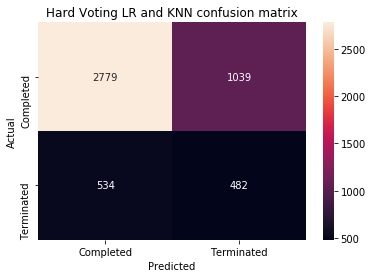

In [258]:
confusion = confusion_matrix(y_validate_cv1, preds_)
sns.heatmap(confusion, annot=True,
           xticklabels=['Completed','Terminated'],
           yticklabels=['Completed','Terminated'],fmt='.0f')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Hard Voting LR and KNN confusion matrix');

In [259]:
print(classification_report(y_validate_cv1, preds_))

              precision    recall  f1-score   support

   Completed       0.84      0.73      0.78      3818
  Terminated       0.32      0.47      0.38      1016

    accuracy                           0.67      4834
   macro avg       0.58      0.60      0.58      4834
weighted avg       0.73      0.67      0.70      4834



This is not as good as the soft classifier for Terminated class

Renaming the models so it uses kNN when the models disagree - didn't seem to work !

In [355]:
model_names=['knn','a_lr']

In [363]:
a_lr = lr

In [364]:
model_vars = [knn, a_lr]

In [365]:
model_list=list(zip(model_names,model_vars))

In [366]:
voting_classifer = VotingClassifier(estimators=model_list, voting='hard', 
                                    n_jobs=-1)
voting_classifer.fit(X_adasyn_cv1, y_adasyn_cv1)

VotingClassifier(estimators=[('knn',
                              KNeighborsClassifier(n_neighbors=4,
                                                   weights='distance')),
                             ('a_lr',
                              LogisticRegression(C=0.1, class_weight='balanced',
                                                 l1_ratio=1, max_iter=500,
                                                 penalty='elasticnet',
                                                 solver='saga'))],
                 n_jobs=-1)

In [367]:
preds_=voting_classifer.predict(X_validate_cv1)

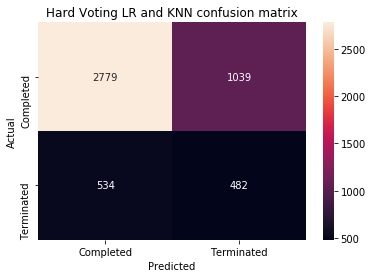

In [368]:
confusion = confusion_matrix(y_validate_cv1, preds_)
sns.heatmap(confusion, annot=True,
           xticklabels=['Completed','Terminated'],
           yticklabels=['Completed','Terminated'],fmt='.0f')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Hard Voting LR and KNN confusion matrix');

In [369]:
print(classification_report(y_validate_cv1, preds_))

              precision    recall  f1-score   support

   Completed       0.84      0.73      0.78      3818
  Terminated       0.32      0.47      0.38      1016

    accuracy                           0.67      4834
   macro avg       0.58      0.60      0.58      4834
weighted avg       0.73      0.67      0.70      4834



## Trying XGBoost, KNN and LR together
### An issue I am having is that the ADASYN imputer package required sci-kitlearn 22 and XGBoost package scikitlean 23

I played with soft voting parameters with the pretrained models manually, but couldn't get better than 0.41 F1 score for 'Terminated

In [12]:
preds_gbm=gbm.predict(X_validate_cv1)
preds_lr=lr.predict_proba(X_validate_cv1)[:,1]
preds_knn=knn.predict_proba(X_validate_cv1)[:,1]

In [198]:
vote_pred = (0.8 * preds_gbm + 0.1 *preds_knn + 0.2 *preds_lr) > 0.35

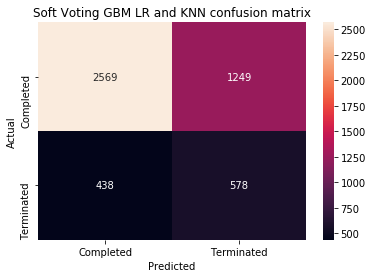

In [199]:
confusion = confusion_matrix(y_validate_01, vote_pred)
sns.heatmap(confusion, annot=True,
           xticklabels=['Completed','Terminated'],
           yticklabels=['Completed','Terminated'],fmt='.0f')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Soft Voting GBM LR and KNN confusion matrix');

In [200]:
print(classification_report(y_validate_01, vote_pred))

              precision    recall  f1-score   support

           0       0.85      0.67      0.75      3818
           1       0.32      0.57      0.41      1016

    accuracy                           0.65      4834
   macro avg       0.59      0.62      0.58      4834
weighted avg       0.74      0.65      0.68      4834



# OK 
## So I am going to go with the Soft Vote KNN and LR combo as my second place model after XGBoost. 
### Training with the full oversampled dataset now

In [371]:
#X_adasyn is the oversampled full training dataset
X_adasyn.shape

(22853, 400)

In [372]:
model_list

[('knn', KNeighborsClassifier(n_neighbors=4, weights='distance')),
 ('a_lr',
  LogisticRegression(C=0.1, class_weight='balanced', l1_ratio=1, max_iter=500,
                     penalty='elasticnet', solver='saga'))]

In [373]:
final_model = VotingClassifier(estimators=model_list,
                                    voting='soft', 
                                    n_jobs=-1)
final_model.fit(X_adasyn, y_adasyn)

VotingClassifier(estimators=[('knn',
                              KNeighborsClassifier(n_neighbors=4,
                                                   weights='distance')),
                             ('a_lr',
                              LogisticRegression(C=0.1, class_weight='balanced',
                                                 l1_ratio=1, max_iter=500,
                                                 penalty='elasticnet',
                                                 solver='saga'))],
                 n_jobs=-1, voting='soft')

In [374]:
with open('final_model.pickle', 'wb') as write_file:
    pickle.dump(final_model, write_file)